In [90]:
import os
import re
import pickle
import spacy
import datetime
import pandas as pd

from tqdm import tqdm

In [2]:
processed_dir = r'D:\data\kaggle_news\processed'
news_text_pklfile = 'dic_all_news_text.pkl'

In [15]:
df_basel_risk_norms = pd.read_csv('risk_mean_basel_risk_norms.csv')
lst_BRN_lower = [x.strip().lower() for x in df_basel_risk_norms.source]

In [112]:
df_basel_risk_norms.head()

,source,rating
0,America,8.921053
1,Antarctic,38.099338
2,Australia,-25.805195
3,Boston,-14.824324
4,California,-21.959184


In [3]:
dic_news_text = pickle.load(open(os.path.join(processed_dir, news_text_pklfile), 'rb'))

In [8]:
nlp = spacy.load('en_core_web_lg')

<b> (Caution) Below for loop takes 5 hours. Use dic_rick_word_in_news.pkl file! </b>

In [17]:
dic_risk_word_in_news = {}
for uuid, dic_text in tqdm(dic_news_text.items()):
    news_text = dic_text['text']
    # split text into words using re
    doc = nlp(news_text)
    tokens = [token for token in doc]
    lemma_lower = [token.lemma_.lower() for token in tokens]
    risk_words = [x for x in lemma_lower if x in lst_BRN_lower]
    if len(risk_words) > 0:
        dic_risk_word_in_news[uuid] = risk_words

100%|██████████| 306188/306188 [5:14:02<00:00, 16.25it/s]   


In [18]:
pickle.dump(dic_risk_word_in_news, open('dic_risk_word_in_news.pkl', 'wb'))

In [19]:
len(dic_risk_word_in_news)

253887

In [20]:
news_meta_file = 'dic_all_news.pkl'
dic_news_meta = pickle.load(open(os.path.join(processed_dir, news_meta_file), 'rb'))

In [21]:
first_key = next(iter(dic_news_meta))

In [23]:
dic_news_meta[first_key]

{'organizations': [],
 'author': '',
 'url': 'https://www.cnbc.com/2018/01/03/emerging-markets-are-set-for-an-even-bigger-rally-in-2018-says-one-technician.html',
 'ord_in_thread': 0,
 'title': 'Emerging markets are set for an even bigger rally in 2018, says one technician',
 'locations': [],
 'highlightText': '',
 'language': 'english',
 'persons': [],
 'external_links': [],
 'published': '2018-01-03T15:00:00.000+02:00',
 'crawled': '2018-01-03T15:34:36.006+02:00',
 'highlightTitle': '',
 'word_cnt': 303}

In [24]:
dic_uuid_pubdate = {key: val['published'] for key, val in dic_news_meta.items()}

In [25]:
len(dic_uuid_pubdate)

306188

In [27]:
df_pubdate = pd.Series(dic_uuid_pubdate)
df_risk = pd.Series(dic_risk_word_in_news)
df_all = pd.concat([df_pubdate, df_risk], axis=1)
df_all.columns = ['pubdate', 'risk_word']
df_all.set_index('pubdate', inplace=True, drop=True)
df_all.index = pd.PeriodIndex(df_all.index, freq='D')
df_all.reset_index(inplace=True)
df_all.head(10)

In [60]:
def get_risk_word(text):
    if isinstance(text, list):
        return int(len(text))
    return text

df_all['num_words'] = df_all['risk_word'].apply(lambda x: get_risk_word(x))

In [78]:
df_all2 = df_all.dropna().sort_index()
df_all2 = df_all2.groupby('pubdate').sum()

In [110]:
df_all2.head(10)

,risk_word,num_words
pubdate,,
2017-12-07,"[internet, tv, desk, people, hotel, technology...",70.0
2017-12-08,"[street, bubble, technology, people, night, te...",36.0
2017-12-10,[vacuum],1.0
2017-12-13,"[smartphone, space]",2.0
2017-12-14,"[park, laptop, ipad, street]",4.0
2017-12-15,"[america, fuel, fall, unemployment, inflation,...",16.0
2017-12-18,"[fall, recovery, manager]",3.0
2017-12-20,[education],1.0
2017-12-21,"[park, exercise, net, exercise, net, chicago, ...",13.0


In [63]:
import pandas_datareader as pdr

In [91]:
start = datetime.datetime(2018,1,1)
end = datetime.datetime(2018,5,31)
vix = pdr.DataReader('VIXCLS', 'fred', start, end).dropna()

In [92]:
vix.index = pd.PeriodIndex(vix.index, freq='D')
df_all3 = pd.merge(df_all2, vix, how='outer', left_index=True, right_index=True)
df_all3 = df_all3.loc['2018-01-01':]
df_all3.ffill().bfill(inplace=True)

#### Questions
- Word cleaning?
- Apply Risk score
- Number of news by date -> normalise

In [107]:
df_all3[['num_words', 'VIXCLS']].corr()

,num_words,VIXCLS
num_words,1.000000,0.101491
VIXCLS,0.101491,1.000000


<Axes: >

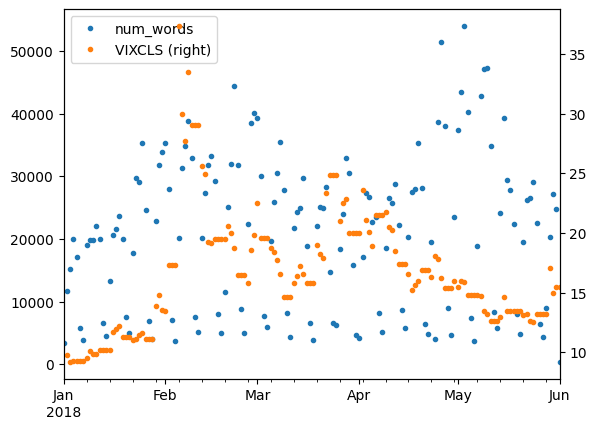

In [106]:
df_all3[['num_words', 'VIXCLS']].plot(style='.',secondary_y='VIXCLS')